# Vulcain Nozzle Extension

This is an extension of the 'Vulcain Combustion Chamber.ipynb' notebook, but here we will attempt to model the dump-cooled nozzle extension here. <b> The key thing to note is that the nozzle extension using <u>spiralling</u> channels</b>.

Note:
The cooling channels taper at the coolant inlet, which must be accounted to consider the extra heat transfer in this section. I have not been able to find details on the taper except an undefined dimension in [2], which I assume to have been a square 'width x height' of 2.8x4 mm.


### References:

- [1] - Kirner et al 1993, Development Status of the Vulcain Thrust Chamber (http://ftp.demec.ufpr.br/CFD/bibliografia/propulsao/kirner_et_al_1993.pdf)
- [2] - Nydén et al 1991, Development of the HM60-Vulcain nozzle extension (https://arc.aiaa.org/doi/10.2514/6.1991-2566)
- [3] - LeBail et al 1993, Numerical analysis of high aspect ratio cooling passage flow and heat transfer (https://arc.aiaa.org/doi/pdf/10.2514/6.1993-1829)
- [4] - High Temp Metals, Inconel 600 Technical Data, (https://www.hightempmetals.com/techdata/hitempInconel600data.php)
- [5] - Ljungkrona et all 1998, Cooling Performance of the Nozzle Extension of the Ariane 5 Core Stage Engine Vulcain (https://arc.aiaa.org/doi/10.2514/6.1998-4012)

In [130]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import json

### Collect Vulcain data

Using a an online graph image-to-data converter (http://www.graphreader.com/), we can obtain the raw data.

In [131]:
data = json.load(open("data/vulcain.json"))

# Cooling channel data
coolant_inlet_p0 = 137.9e5          # Coolant inlet pressure [3] (guess that p0 ~= p)
mdot_coolant = 1.75                 # Coolant mass flow rate [2] 
k_wall = 19.2                       # Wall thermal conductivity [4] for Inconel 600 [1]
wall_thickness = 0.4e-3             # Wall thickness between coolant and exhaust gas [2]
number_of_channels = 456            # Number of channels [2]
channel_height = 3.2e-3             # Height of cooling channels [2]

# Fraction of cooling channel flow area that is blocked by fins/walls [2]
x_taper_start = data["Kirner"]["Extension Contour"]["x"][0]
x_taper_end = np.interp(0.15, 
                        [0, 4.15], 
                        [data["Kirner"]["Extension Contour"]["x"][0], data["Kirner"]["Extension Contour"]["x"][-1]])

def blockage_ratio(x):  
    if x < x_taper_end:
        return 0.2857     # (0.4 + 0.4) / 2.8
    else:    
        return 0.2        # (0.4 + 0.4) / 4                
    
pitch = 1.824                        # Cooling channel helix pitch [2] - number of tubes * width of each tube

# Chamber conditions data
thrust = 1007.7e3   # Vacuum thrust, N [1]
isp = 439*9.81      # Specific impulse, m/s [1]
pc = 100e5          # Chamber pressure, bar [1]
OF_ratio = 5.6      # O/F ratio (seems to be by mass) [1]

### Get chamber conditions

Use pypropep. The Vulcain uses a liquid oxygen and liquid hydrogen fed system.

In [132]:
# Use pypropep to get chamber temperature
ppp.init()
p_froz = ppp.FrozenPerformance()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

# Add propellants by mass fractions
p_froz.add_propellants_by_mass([(lox, OF_ratio), (lh2, 1)])

# Adiabatic combustion using chamber pressure                      
p_froz.set_state(P = pc/1e5, Pe = 1)   

# Get results - use throat conditions for gamma and cp! Otherwise the perfect gas model deviates a lot from equilibrium calculations.
gamma = p_froz.properties[1].Isex   # pyrpopep uses 'Isex' for the ratio of specific heats. Index 1 means throat conditions
cp = 1000*p_froz.properties[1].Cp   # Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T         # Index 0 means chamber conditions

print(f"Chamber temperature = {Tc} K")

print("\nCombustion product composition:")
print(p_froz.composition["throat"])

Loaded 1921 thermo species
Loaded 1031 propellants
Chamber temperature = 3459.2606127242298 K

Combustion product composition:
[('H2O', 0.6493671319106238), ('H2', 0.2896925690851782), ('OH', 0.028980423622929952), ('H', 0.028801796474919292), ('O', 0.0016810512414820072), ('O2', 0.0014520541971763574), ('HO2', 1.7031381331243065e-05), ('H2O2', 7.94208687267654e-06), ('O3', 0.0)]


### Bamboo engine model

First set up the perfect gas model, the geometry, and combustion chamber conditions. Use this to get the mass flow rate of exhaust gas.

In [133]:
# Set up the chamber conditions and geometry
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)   
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)
geometry = bam.Geometry(xs = data["Kirner"]["Engine Contour"]["x"], 
                        ys = data["Kirner"]["Engine Contour"]["y"])

# Set up an engine quickly just to get our perfect gas mass flow rate (used later)
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry)

Now use Cantera to get the exhaust gas transport properties, and CoolProp to get the coolant transport properties.

In [134]:
# Setup the exhaust gas transport properties using Cantera
gas = ct.Solution('gri30.yaml')
gas.TPY = Tc, pc, f"H2:{1}, O2:{OF_ratio}"
gas.equilibrate("TP")

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

# Set up the coolant transport properties using CoolProp
# Round temperatures up to 12 K - CoolProp seems unhappy below this for LH2
def Pr_coolant(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN")

def rho_coolant(T, p):
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

# Note that H2 doesn't seem to exactly 'boil-off' in the state it's in - it's supercritical
coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

Put the final pieces together, set up the `Engine` object, and plot the geometry.

In [135]:
cooling_jacket = bam.CoolingJacket(T_coolant_in = data["Kirner"]["Extension Coolant Temperature (Sim)"]["y"][0],                           
                                   p0_coolant_in = coolant_inlet_p0, 
                                   coolant_transport = coolant_transport, 
                                   mdot_coolant = mdot_coolant, 
                                   configuration = "spiral", 
                                   channel_height = channel_height,
                                   number_of_fins = number_of_channels,
                                   blockage_ratio = blockage_ratio,
                                   pitch = pitch,
                                   xs = [data["Kirner"]["Extension Contour"]["x"][0], 
                                         data["Kirner"]["Extension Contour"]["x"][-1]])

wall = bam.Wall(material = bam.Material(k = k_wall), thickness = wall_thickness)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    cooling_jacket = cooling_jacket,
                    exhaust_transport = exhaust_transport,
                    walls = wall,
                    coolant_convection = "dittus-boelter",
                    exhaust_convection = "bartz-sigma",
                    h_exhaust_sf = 1.27,
                    h_coolant_sf = 1.3)

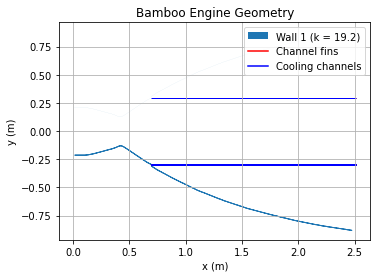

In [136]:
# Run simulation
bamboo_results = engine.steady_heating_analysis(counterflow = False)
engine.plot()
plt.title("Bamboo Engine Geometry")
plt.show()

In [137]:
print(bamboo_results["info"]["T"])

Temperature at each position (K). T[i][j], is the temperature at x[i], at the j'th wall boundary. j = 0 corresponds to the coolant, j = -1 corresponds to the exhaust gas.


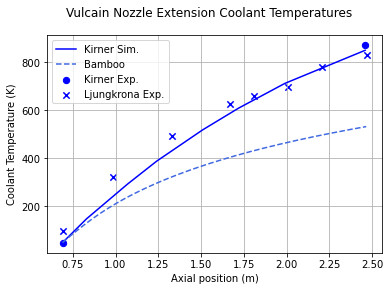

Experimental coolant exit temperature (Kirner) = 871.91 K
Predicted coolant exit temperature (Bamboo) = 532.92 K
Percentage error in coolant exit temperature = 38.88%



In [138]:
# Plot coolant temperatures
fig, ax = plt.subplots()
fig.suptitle("Vulcain Nozzle Extension Coolant Temperatures")

# Plot coolant temperatures      
ax.plot(data["Kirner"]["Extension Coolant Temperature (Sim)"]["x"], 
        data["Kirner"]["Extension Coolant Temperature (Sim)"]["y"], 
        label = "Kirner Sim.", 
        color= "blue")

ax.plot(bamboo_results["x"], 
        bamboo_results["T_coolant"], 
        label= "Bamboo", 
        color= "royalblue", 
        linestyle = "--")

# Plot their experimental datapoints
ax.scatter(data["Kirner"]["Extension Coolant Temperature (Exp)"]["x"],
           data["Kirner"]["Extension Coolant Temperature (Exp)"]["y"], 
           s = 40, 
           marker = 'o', 
           color = "blue",
           label = "Kirner Exp.")

ax.scatter(data["Ljungkrona"]["Extension Coolant Temperature (Exp)"]["x"], 
           data["Ljungkrona"]["Extension Coolant Temperature (Exp)"]["y"], 
           s = 40, 
           marker = 'x', 
           color = "blue",
           label = "Ljungkrona Exp.")

# Formatting
ax.set_ylabel("Coolant Temperature (K)")
ax.set_xlabel("Axial position (m)")
ax.grid()
ax.legend()
plt.show()

print(f'Experimental coolant exit temperature (Kirner) = {data["Kirner"]["Extension Coolant Temperature (Exp)"]["y"][-1]:.2f} K')
print(f'Predicted coolant exit temperature (Bamboo) = {bamboo_results["T_coolant"][-1]:.2f} K')
percent_error = 100*(bamboo_results["T_coolant"][-1] - data["Kirner"]["Extension Coolant Temperature (Exp)"]["y"][-1])/data["Kirner"]["Extension Coolant Temperature (Exp)"]["y"][-1]
print(f'Percentage error in coolant exit temperature = {abs(percent_error):.2f}%\n')

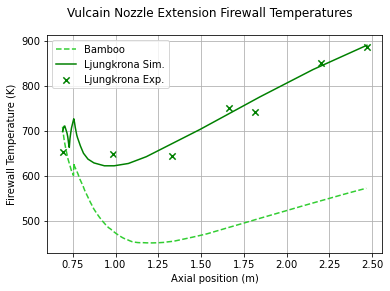

In [139]:
# Plot exhaust side wall temperatures
fig, ax = plt.subplots()
fig.suptitle("Vulcain Nozzle Extension Firewall Temperatures")

# Plot wall temperatures      
ax.plot(bamboo_results["x"], 
        np.array(bamboo_results["T"])[:,2], 
        label= "Bamboo", 
        color= "limegreen", 
        linestyle = "--")

# Plot their simulation data
ax.plot(data["Ljungkrona"]["Extension Firewall Temperature (Sim)"]["x"],
        data["Ljungkrona"]["Extension Firewall Temperature (Sim)"]["y"], 
        label= "Ljungkrona Sim.", 
        color= "green")

# Plot their experimental datapoints
ax.scatter(data["Ljungkrona"]["Extension Firewall Temperature (Exp)"]["x"], 
           data["Ljungkrona"]["Extension Firewall Temperature (Exp)"]["y"], 
           s = 40, 
           marker = 'x', 
           color = "green",
           label = "Ljungkrona Exp.")

# Formatting
ax.set_ylabel("Firewall Temperature (K)")
ax.set_xlabel("Axial position (m)")
ax.grid()
ax.legend()
plt.show()

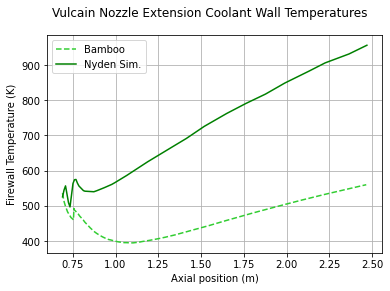

In [140]:
# Plot coolant side wall temperatures
fig, ax = plt.subplots()
fig.suptitle("Vulcain Nozzle Extension Coolant Wall Temperatures")

# Plot wall temperatures      
ax.plot(bamboo_results["x"], 
        np.array(bamboo_results["T"])[:,1], 
        label= "Bamboo", 
        color= "limegreen", 
        linestyle = "--")

# Plot their simulation data
ax.plot(data["Nyden"]["Cooling Side Wall Temperature (Sim)"]["x"],
        data["Nyden"]["Cooling Side Wall Temperature (Sim)"]["y"], 
        label= "Nyden Sim.", 
        color= "green")

# Formatting
ax.set_ylabel("Firewall Temperature (K)")
ax.set_xlabel("Axial position (m)")
ax.grid()
ax.legend()
plt.show()

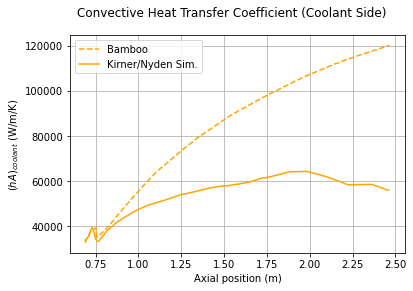

In [141]:
# Compare the convective heat transfer coefficients on the coolant side
fig, ax = plt.subplots()
fig.suptitle("Convective Heat Transfer Coefficient (Coolant Side)")

# Estimate the convective heat transfer coefficient from the simulation data they have
# mdot cp dT/dx = dQ/dx
x_kirner = data["Kirner"]["Extension Coolant Temperature (Sim)"]["x"]

# Quadratic fit to data to smooth it
T_cool_kirner_quad = np.poly1d(np.polyfit(data["Kirner"]["Extension Coolant Temperature (Sim)"]["x"], data["Kirner"]["Extension Coolant Temperature (Sim)"]["y"], 2))

dT_dx_kirner = np.gradient(T_cool_kirner_quad(x_kirner), 
                           x_kirner)

# Estimate cp using CoolProp - assume constant pressure
cp_kirner = cp_coolant(T = data["Kirner"]["Extension Coolant Temperature (Sim)"]["y"],
                       p = coolant_inlet_p0)

dQ_dx_kirner = mdot_coolant * cp_kirner * dT_dx_kirner

Twc_to_kirner = np.interp(x_kirner, 
                          data["Nyden"]["Cooling Side Wall Temperature (Sim)"]["x"],
                          data["Nyden"]["Cooling Side Wall Temperature (Sim)"]["y"])

delta_T_kirner = Twc_to_kirner - np.array(data["Kirner"]["Extension Coolant Temperature (Sim)"]["y"])

hA_cool_kirner = abs(dQ_dx_kirner / delta_T_kirner)

# Now calculate the same thing for Bamboo
dQ_dx_bamboo = np.array(bamboo_results["dQ_dx"])
delta_T_bamboo = np.array(bamboo_results["T_coolant"]) - np.array(bamboo_results["T"])[:, 1]
hA_c_bamboo = abs(dQ_dx_bamboo / delta_T_bamboo)

# Plot   
ax.plot(bamboo_results["x"], 
        hA_c_bamboo, 
        label= "Bamboo", 
        color= "orange", 
        linestyle = "--")

# Plot their simulation data
ax.plot(x_kirner,
        hA_cool_kirner, 
        label= "Kirner/Nyden Sim.", 
        color= "orange")


# Formatting
ax.set_ylabel(r"$(hA)_{coolant}$ (W/m/K)")
ax.set_xlabel("Axial position (m)")
ax.grid()
ax.legend()
plt.show()

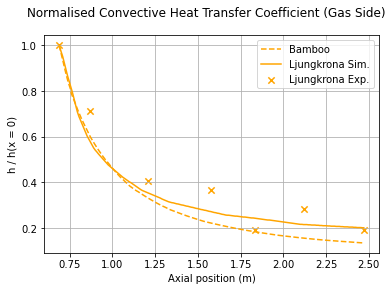

In [142]:
# Plot exhaust side wall temperatures
fig, ax = plt.subplots()
fig.suptitle("Normalised Convective Heat Transfer Coefficient (Gas Side)")

# Calculate the normalised convective heat transfer coefficient from bamboo
h_by_h0 = np.array(bamboo_results["dQ_dA"]) / ( np.array(bamboo_results["T"])[:,-1] - np.array(bamboo_results["T"])[:,-2])
h_by_h0 = h_by_h0 / h_by_h0[0]
h_by_h0 = abs(h_by_h0)                                     

# Plot wall temperatures      
ax.plot(bamboo_results["x"], 
        h_by_h0, 
        label= "Bamboo", 
        color= "orange", 
        linestyle = "--")

# Plot their simulation data
ax.plot(data["Ljungkrona"]["Extension Normalised Convective Coefficient (Sim)"]["x"],
        data["Ljungkrona"]["Extension Normalised Convective Coefficient (Sim)"]["y"], 
        label= "Ljungkrona Sim.", 
        color= "orange")

# Plot their experimental datapoints
ax.scatter(data["Ljungkrona"]["Extension Normalised Convective Coefficient (Exp)"]["x"], 
           data["Ljungkrona"]["Extension Normalised Convective Coefficient (Exp)"]["y"], 
           s = 40, 
           marker = 'x', 
           color = "orange",
           label = "Ljungkrona Exp.")

# Formatting
ax.set_ylabel("h / h(x = 0)")
ax.set_xlabel("Axial position (m)")
ax.grid()
ax.legend()
plt.show()

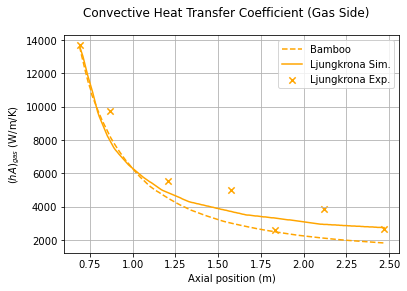

In [143]:
# Replot firewall convective heat transfer, but guess the value of h at x = 0 so we have unscaled values

h0_bamboo = bamboo_results["dQ_dx"][0] / (bamboo_results["T"][0][-1] - bamboo_results["T"][0][-2])

h0_kirner = dQ_dx_kirner[0] /  (bamboo_results["T"][0][-1] - data["Ljungkrona"]["Extension Firewall Temperature (Sim)"]["y"][0])

# Plot as before but scaled
# Plot exhaust side wall temperatures
fig, ax = plt.subplots()
fig.suptitle("Convective Heat Transfer Coefficient (Gas Side)")                               

# Plot wall temperatures      
ax.plot(bamboo_results["x"], 
        h0_bamboo * h_by_h0, 
        label= "Bamboo", 
        color= "orange", 
        linestyle = "--")

# Plot their simulation data
ax.plot(data["Ljungkrona"]["Extension Normalised Convective Coefficient (Sim)"]["x"],
        h0_kirner * np.array(data["Ljungkrona"]["Extension Normalised Convective Coefficient (Sim)"]["y"]), 
        label= "Ljungkrona Sim.", 
        color= "orange")

# Plot their experimental datapoints
ax.scatter(data["Ljungkrona"]["Extension Normalised Convective Coefficient (Exp)"]["x"], 
           h0_kirner * np.array(data["Ljungkrona"]["Extension Normalised Convective Coefficient (Exp)"]["y"]), 
           s = 40, 
           marker = 'x', 
           color = "orange",
           label = "Ljungkrona Exp.")

# Formatting
ax.set_ylabel(r"$(hA)_{gas}$ (W/m/K)")
ax.set_xlabel("Axial position (m)")
ax.grid()
ax.legend()
plt.show()

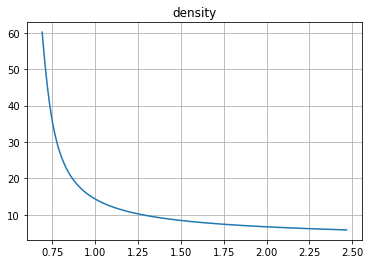

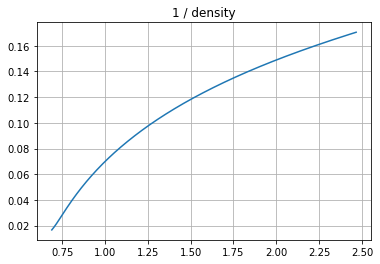

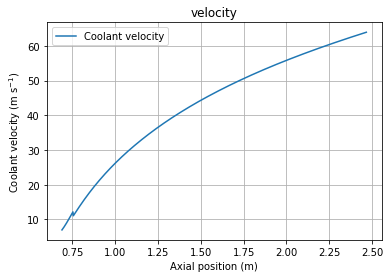

In [144]:
plt.title("density")
plt.plot(bamboo_results["x"], bamboo_results["rho_coolant"])
plt.grid()
plt.show()

plt.title("1 / density")
plt.plot(bamboo_results["x"], 1 / np.array(bamboo_results["rho_coolant"]))
plt.grid()
plt.show()

bam.plot.plot_coolant_velocity(bamboo_results)
plt.title("velocity")
plt.show()

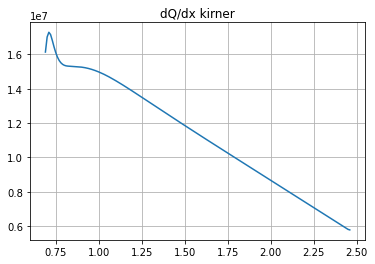

In [145]:
plt.plot(x_kirner, dQ_dx_kirner)
plt.title("dQ/dx kirner")
plt.grid()
plt.show()